# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [955]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [956]:
data = pd.read_csv('toan_adult_data_train.csv')
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,HS-grad,9,Never-married,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0


In [957]:
# data.drop(['education', 'marital-status'], axis=1, inplace=True)

In [958]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,HS-grad,9,Never-married,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0


Определите количество числовых и нечисловых признаков.

In [959]:
len(data.columns)

15

In [960]:
numerical_features = data.select_dtypes(include=['int', 'float']).columns
len(numerical_features) # numerical features

7

In [961]:
len(data.select_dtypes(include=['object']).columns) # non-numerial feature

8

Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

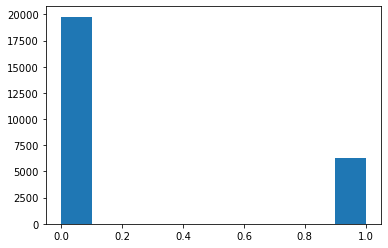

In [962]:
his = plt.hist(data['label'])

In [963]:
num_class_0 = len(data[data['label'] == 0])
total_class = len(data)
ratio_class_0 = num_class_0/total_class

print('Ratio of class 0:', ratio_class_0)

Ratio of class 0: 0.7591753685503686


In [964]:
# data = pd.get_dummies(data, dtype=int)

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных. 

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [965]:
X = data[data.select_dtypes(include=['int', 'float']).columns]
X = X.drop(['label'], axis=1)
Y = data['label']

In [966]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=11, stratify=Y)

In [967]:
X_test['fnlwgt'].mean()

189834.19923224568

In [968]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f1_score(y_test, y_pred))

0.3689119170984456


Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [969]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train)
X_train_scaled = minMaxScaler.transform(X_train)
X_test_scaled = minMaxScaler.transform(X_test)

In [970]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [971]:
X_train_scaled['fnlwgt'].mean()

0.1207255804009474

In [972]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print(f1_score(y_test, y_pred))

0.5092250922509226


Видно, что после линейной нормировки качество выросло. 

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>). 

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

In [973]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,HS-grad,9,Never-married,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0


<AxesSubplot:xlabel='sex', ylabel='label'>

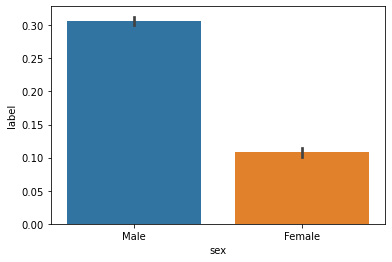

In [974]:
sns.barplot(x='sex', y='label', data=data)

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [975]:
origin_data = data.copy()

In [976]:
data = data.replace("?", np.nan)

In [977]:
missing_values = data.isna()

In [978]:
rows_with_missing = missing_values.any(axis=1)


In [979]:
num_rows_with_missing = np.sum(rows_with_missing)

num_rows_with_missing

1914

In [980]:

data = data.dropna(axis=0, how='any')

In [981]:
data = pd.get_dummies(data, dtype=int)

In [982]:
data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32,37210,13,0,0,45,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,43,101950,14,0,0,45,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,40,24763,10,6849,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,24,113936,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,51,237630,9,7298,0,50,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них. 

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [983]:
data.shape

(24134, 105)

Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [984]:
X = data.drop('label', axis=1)
Y = data['label']

In [985]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=11, stratify=Y)

In [986]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train)
X_train_scaled = minMaxScaler.transform(X_train)
X_test_scaled = minMaxScaler.transform(X_test)

In [987]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [988]:
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print(f1_score(y_test, y_pred))

0.6184210526315789


Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [989]:
data = origin_data.copy()

In [990]:
data = data.replace("?", np.nan)

In [991]:
# Tính giá trị phổ biến nhất của từng cột
most_common_values = data.apply(lambda x: x.value_counts().index[0])

In [992]:
data = data.fillna(most_common_values.to_dict())

In [993]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,Private,122244,HS-grad,9,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0


### Perform outliner remove


In [994]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label
count,26048.000000,2.604800e+04,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000
mean,38.589373,1.900018e+05,10.079661,1060.682740,88.026259,40.480728,0.240825
std,13.641016,1.055103e+05,2.583186,7299.149781,404.983608,12.417613,0.427592
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.181942e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.785535e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.374578e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


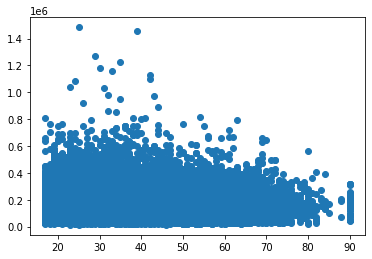

In [995]:
plt.scatter(data['age'], data['fnlwgt'])

In [996]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [997]:
outliers = find_outliers_IQR(data['age'])

outliers

72       82
559      79
617      79
714      90
722      79
         ..
25235    83
25314    81
25775    81
25818    80
25836    84
Name: age, Length: 118, dtype: int64

In [998]:
def impute_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   upper = df[~(df>(q3+1.5*IQR))].max()
   lower = df[~(df<(q1-1.5*IQR))].min()
   df = np.where(df > upper,
       df.mean(),
       np.where(
           df < lower,
           df.mean(),
           df
           )
       )
   return df

#### Perform remove outliner

In [999]:
for features in numerical_features:
    if features == 'label':
        continue
    data[features] = impute_outliers_IQR(data[features])

In [1000]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label
count,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000,26048.000000
mean,38.384004,180303.481511,10.337142,87.507955,4.132990,41.258686,0.240825
std,13.290383,86201.815413,2.198560,291.828382,18.621045,3.439918,0.427592
min,17.000000,12285.000000,5.000000,0.000000,0.000000,33.000000,0.000000
25%,28.000000,118194.250000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,178553.500000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,226402.500000,12.000000,0.000000,0.000000,40.480728,0.000000
max,78.000000,416338.000000,16.000000,1060.682740,88.026259,52.000000,1.000000


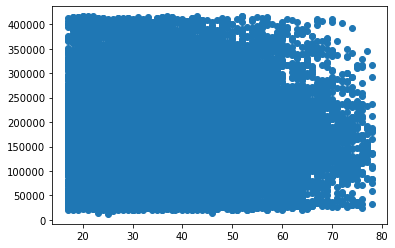

In [1001]:
plt.scatter(data['age'], data['fnlwgt'])

### One-hot

Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [1002]:
data = pd.get_dummies(data, dtype=int)

In [1003]:
data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32.0,37210.0,13.0,0.00000,0.0,45.000000,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,43.0,101950.0,14.0,0.00000,0.0,45.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,20.0,122244.0,9.0,0.00000,0.0,40.480728,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,40.0,24763.0,10.0,1060.68274,0.0,40.000000,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,24.0,113936.0,13.0,0.00000,0.0,40.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [1004]:
X = data.drop('label', axis=1)
Y = data['label']

In [1005]:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,32.0,37210.0,13.0,0.00000,0.0,45.000000,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,43.0,101950.0,14.0,0.00000,0.0,45.000000,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,20.0,122244.0,9.0,0.00000,0.0,40.480728,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,40.0,24763.0,10.0,1060.68274,0.0,40.000000,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,24.0,113936.0,13.0,0.00000,0.0,40.000000,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


### Split

In [1006]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=11, stratify=Y)

### Scaling

In [1007]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X)
X_train_scaled = minMaxScaler.transform(X_train)
X_test_scaled = minMaxScaler.transform(X_test)
X_scaled = minMaxScaler.transform(X)

In [1008]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### Train

In [1009]:
# max_score = 0
# max_k = 0
# for i in range(2, 6):
knn = KNeighborsClassifier(n_neighbors=95, p=2, metric='minkowski', weights='distance')

knn.fit(X_scaled, Y)

# k_range = range(1000, 10010)
# k_scores = []
# for k in k_range:
#     knn.n_neighbors = k
#     knn.fit(X_train_scaled, y_train)
#     y_pred = knn.predict(X_test_scaled)
#     # scores = cross_val_score(knn, y_pred.reshape(-1, 1), y_test.to_numpy(), cv=10, scoring='accuracy')
#     scores = f1_score(y_test, y_pred)
#     k_scores.append(scores.mean())

# plt.plot(k_range, k_scores)
# plt.xlabel('Số lượng láng giềng k')
# plt.ylabel('Độ chính xác trên tập kiểm tra')
# plt.show()

y_pred = knn.predict(X_test_scaled)
score = f1_score(y_test, y_pred)
print(score)

/home/huynh/.local/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


1.0


### Validate

In [1010]:
data_reserved = pd.read_csv('toan_adult_data_reserved.csv')

In [1011]:
# data_reserved.drop(['education', 'marital-status'], axis=1, inplace=True)

In [1012]:
data_reserved = data_reserved.replace("?", np.nan)

In [1013]:
# Tính giá trị phổ biến nhất của từng cột
most_common_values = data_reserved.apply(lambda x: x.value_counts().index[0])

In [1014]:
data_reserved = data_reserved.fillna(most_common_values.to_dict())

In [1015]:
data_reserved = pd.get_dummies(data_reserved, dtype=int)

In [1016]:
data_reserved['native-country_Holand-Netherlands'] = 0


In [1017]:
data_reserved =  data_reserved.reindex(columns=X.columns)

In [1018]:
data_reserved.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,31,117963,16,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,20,201490,10,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,78,385242,13,9386,0,45,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,32,164197,13,0,0,44,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,61,92691,9,0,0,3,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [1019]:
X_reserved = data_reserved

In [1020]:
X_reserved_scaled = minMaxScaler.transform(X_reserved)

In [1021]:
y_reserved_pred = knn.predict(X_reserved_scaled)

In [ ]:
y_reserved_pred = pd.DataFrame(y_reserved_pred, columns=['label'])

In [ ]:
y_reserved_pred.T.to_csv('y_reserved_pred.csv', index=False, header=False)

## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.